In [3]:
import torch

import sys
sys.path.append('..')

from Data import load_and_prepare_dataset_for_layoutLM
from transformers import LayoutLMForTokenClassification
from Training import fine_tune_model, evaluate_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
id2label, label2id, train_dataloader, val_dataloader, test_dataloader = load_and_prepare_dataset_for_layoutLM(batch_size=2)

Map: 100%|██████████| 50/50 [00:00<00:00, 55.77 examples/s]


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use 'cuda' instead of 'mps' if running on a GPU machine that is not provided by MacOS

In [ ]:
import pickle

NUM_EXPERIMENTS = 5
training_losses_list, val_losses_list, training_f1s_list, val_f1s_list, training_accs_list, val_accs_list = [], [], [], [], [], []
results_list = []

for _ in range(NUM_EXPERIMENTS):

    model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label),id2label=id2label, label2id=label2id)
    
    training_losses, val_losses, training_f1s, val_f1s, training_accs, val_accs = fine_tune_model(
        model=model,
        device=device,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        id2label=id2label,
        num_epoch_max=5,
        lr=5e-5,
        early_stopping=True,
        test_frequency=1
    )
    training_losses_list.append(training_losses)
    val_losses_list.append(val_losses)
    training_f1s_list.append(training_f1s)
    val_f1s_list.append(val_f1s)
    training_accs_list.append(training_accs)
    val_accs_list.append(val_accs)

    model.load_state_dict(torch.load('../Saved_Models/Full_fine_tuning/Best.pth'))

    results = evaluate_model(
        model=model,
        device=device,
        test_dataloader=test_dataloader,
        original_id2label=id2label
    )

    results['training_losses_list'] = training_losses_list,
    results['val_losses_list'] = val_losses_list,
    results['training_f1s_list'] = training_f1s_list,
    results['val_f1s_list'] = val_f1s_list,
    results['training_accs_list'] = training_accs_list,
    results['val_accs_list'] = val_accs_list,

    results_list.append(results)

    with open('results_list_full_fine_tune.pkl', 'wb') as f:
        pickle.dump(results_list, f)

In [ ]:
# Concatenate with pre-existing result-list
try:
    with open('results_list_full_fine_tune_all.pkl', 'rb') as f:
        all_results_list = pickle.load(f)
except:
    all_results_list = []

with open('results_list_full_fine_tune.pkl', 'rb') as f:
        all_results_list.extend(pickle.load(f))

with open('results_list_full_fine_tune_all.pkl', 'wb') as f:
        pickle.dump(all_results_list, f)

In [ ]:
metrics_list = ['training_losses_list','val_losses_list','training_f1s_list','val_f1s_list','training_accs_list','val_accs_list']

with open('results_list_full_fine_tune_all.pkl', 'rb') as f:
    all_results_list = pickle.load(f)

training_metrics = {}
for d in all_results_list:
    for k in metrics_list:
        if k not in training_metrics:
            training_metrics[k] = d[k]
        else:
            training_metrics[k].extend(d[k])

for key, value in training_metrics.items():
    globals()[key] = value

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

NUM_EXPERIMENTS = len(training_metrics['training_losses_list'])

def aggregate_line_results(metric_list, num_experiments = NUM_EXPERIMENTS):

    x_values = np.linspace(1, len(metric_list[0]), len(metric_list[0]))
    results = np.array(metric_list)

    # Calculate mean and standard deviation for each x-value
    mean_curve = np.mean(results, axis=0)
    std_curve = np.std(results, axis=0, ddof=1)  # ddof=1 for sample standard deviation

    # Calculate confidence interval at 90% level
    confidence_interval_upper = mean_curve + 1.96 * std_curve / np.sqrt(num_experiments)
    confidence_interval_lower = mean_curve - 1.96 * std_curve / np.sqrt(num_experiments)

    return x_values, mean_curve, confidence_interval_lower, confidence_interval_upper


def plot_line_results(ax: plt.Axes, 
                        x_values, 
                        mean_curve1, 
                        confidence_interval_lower1, 
                        confidence_interval_upper1, 
                        label1,
                        mean_curve2, 
                        confidence_interval_lower2, 
                        confidence_interval_upper2, 
                        label2,
                        fill_between = True):
    # Plot the first mean curve
    ax.plot(x_values, mean_curve1, color='red', label=label1)

    # Plot the first confidence interval as a shaded region
    if fill_between:
        ax.fill_between(x_values, confidence_interval_lower1, confidence_interval_upper1, color='gray', alpha=0.3)

    # If the second curve is provided, plot it
    if mean_curve2 is not None:
        ax.plot(x_values, mean_curve2, color='blue', label=label2)

        # Plot the second confidence interval as a shaded region
        if fill_between:
            ax.fill_between(x_values, confidence_interval_lower2, confidence_interval_upper2, color='lightblue', alpha=0.3)

    ax.legend()

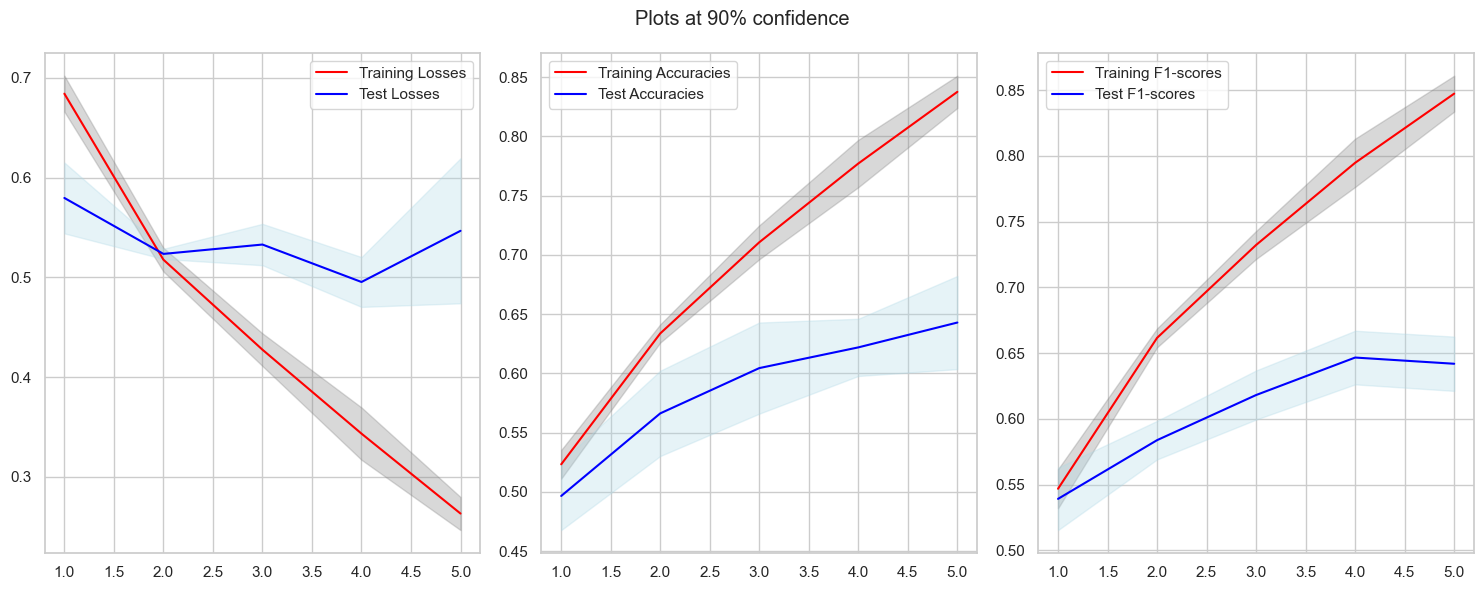

In [7]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Loss plot
x_values_train, mean_curve_train, ci_lower_train, ci_upper_train = aggregate_line_results(training_losses_list)
x_values_val, mean_curve_val, ci_lower_val, ci_upper_val = aggregate_line_results(val_losses_list)
plot_line_results(axs[0], x_values_train, mean_curve_train, ci_lower_train, ci_upper_train, 'Training Losses', mean_curve_val, ci_lower_val, ci_upper_val, 'Test Losses')

# Accuracy plot
x_values_train, mean_curve_train, ci_lower_train, ci_upper_train = aggregate_line_results(training_accs_list)
x_values_val, mean_curve_val, ci_lower_val, ci_upper_val = aggregate_line_results(val_accs_list)
plot_line_results(axs[1], x_values_train, mean_curve_train, ci_lower_train, ci_upper_train, 'Training Accuracies', mean_curve_val, ci_lower_val, ci_upper_val, 'Test Accuracies')

# F1-score plot
x_values_train, mean_curve_train, ci_lower_train, ci_upper_train = aggregate_line_results(training_f1s_list)
x_values_val, mean_curve_val, ci_lower_val, ci_upper_val = aggregate_line_results(val_f1s_list)
plot_line_results(axs[2], x_values_train, mean_curve_train, ci_lower_train, ci_upper_train, 'Training F1-scores', mean_curve_val, ci_lower_val, ci_upper_val, 'Test F1-scores')

fig.suptitle('Plots at 90% confidence')

plt.tight_layout()
plt.show()

In [9]:
all_results_list[0]['metrics_tokens']

,Precision,Recall,F1
B-HEADER,0.500000,0.446429,0.471698
I-HEADER,0.469388,0.550898,0.506887
B-QUESTION,0.651992,0.758537,0.701240
I-QUESTION,0.611004,0.694079,0.649897
B-ANSWER,0.686893,0.659674,0.673008
I-ANSWER,0.683683,0.670841,0.677201


<Axes: >

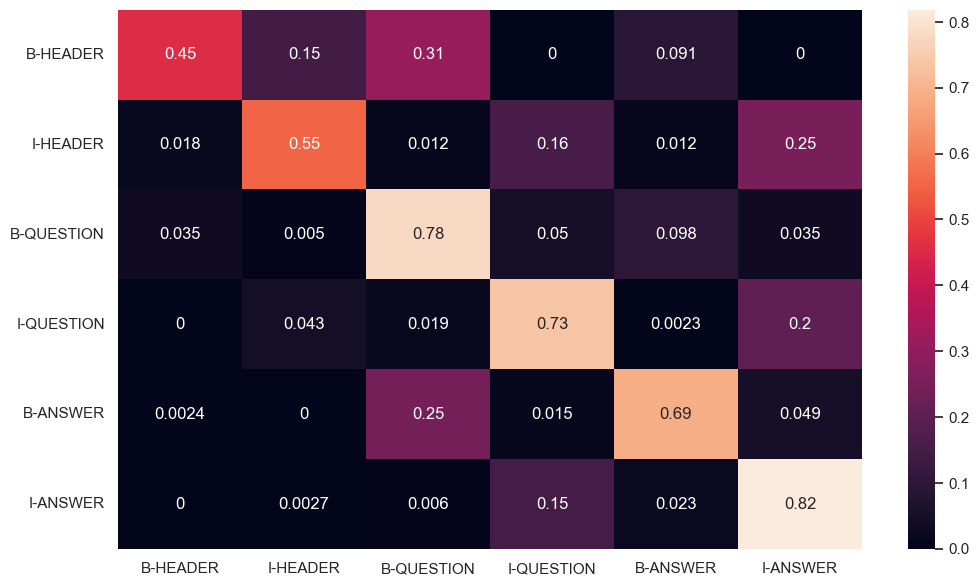

In [10]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize = (12,7))
sn.heatmap(all_results_list[0]["conf_matrix_tokens"], annot=True)

<Axes: >

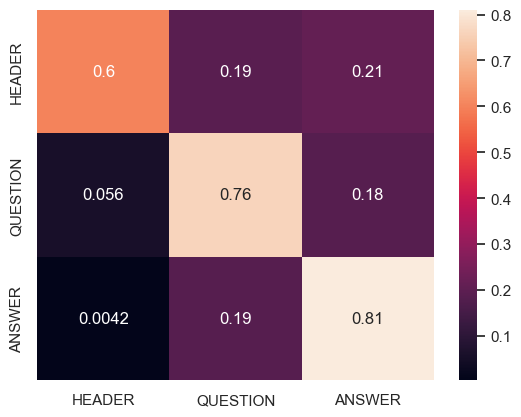

In [12]:
sn.heatmap(all_results_list[0]["conf_matrix_words"], annot=True)

In [13]:
import numpy as np

def aggregate_metrics_results(metrics_arrays_list):

    # Convert the list of arrays to a NumPy array
    arrays_array = np.array(metrics_arrays_list)

    # Calculate the mean and standard deviation
    mean_array = np.mean(arrays_array, axis=0)
    std_dev_array = np.std(arrays_array, axis=0, ddof=1)

    new_array = np.empty(mean_array.shape, dtype='U16')
    for i in range(new_array.shape[0]):
        for j in range(new_array.shape[1]):
            new_array[i, j] = str(round(mean_array[i, j], 3)) + ' \u00B1 ' + str(round(1.96 * std_dev_array[i, j], 3))

    return new_array

In [14]:
for key in ['metrics_tokens', 'metrics_words']:
    globals()['globals_' + key] = results_list[0][key].copy().astype(str)
    aggregated_values = aggregate_metrics_results([np.array(result[key]) for result in results_list])
    globals()['globals_' + key].values[:] = aggregated_values

In [15]:
L = []
for result_dict in results_list:
    result_df = result_dict['metrics_tokens']
    L.append(result_df.loc['I-HEADER', 'Precision'])

In [16]:
import numpy as np

L = np.array(L)
print(np.mean(L))
print(np.std(L))

0.45671184079608607
0.09871122489404091


In [17]:
globals_metrics_tokens

,Precision,Recall,F1
B-HEADER,0.562 ± 0.378,0.393 ± 0.126,0.443 ± 0.04
I-HEADER,0.457 ± 0.216,0.485 ± 0.257,0.447 ± 0.091
B-QUESTION,0.659 ± 0.052,0.79 ± 0.043,0.719 ± 0.037
I-QUESTION,0.611 ± 0.103,0.703 ± 0.078,0.653 ± 0.067
B-ANSWER,0.682 ± 0.019,0.681 ± 0.101,0.681 ± 0.045
I-ANSWER,0.687 ± 0.022,0.768 ± 0.114,0.724 ± 0.056


In [18]:
globals_metrics_words

,Precision,Recall,F1
HEADER,0.477 ± 0.265,0.511 ± 0.265,0.468 ± 0.084
QUESTION,0.631 ± 0.058,0.741 ± 0.046,0.681 ± 0.044
ANSWER,0.709 ± 0.039,0.758 ± 0.121,0.732 ± 0.067


In [20]:
f1_score = np.mean([d['f1'] for d in results_list])
print(f1_score)

0.7008365451445442


In [22]:
precision = np.mean([d['precision'] for d in results_list])
print(precision)

0.667389711756952
